# Geodatenanalyse 2: Termin Explainable AI (XAI)

Ziel der Übung: Für ein einfaches Random Forest Regressions-Modell wollen wir sehen, welche der Input-Parameter inwiefern zur Lösung beitragen.

Wir nutzen dazu die Grundwasser-Daten aus Übung 5 und bauen ein RF-Modell wie in Übung 4 auf, das uns aus den restlichen Input-Parametern den Nitrat-Wert vorhersagen soll.


In [1]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Methods
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Einladen der Daten
filename = 'gwdata_2005.csv'
dataset = pd.read_csv(filename, delimiter=';', encoding='latin1')

# Prüfen auf Nan-Werte
dataset.isnull().sum()

# Pre-processing
dataset_cleaned = dataset.dropna()

mydata = dataset_cleaned.drop(['GWNum','Messstelle','Rechtswert', 'Hochwert', 'Aquifer','Aquifer2','landuse'], axis=1)
mydata.head()

# Spalten umsortieren, damit Nitrat als letztes steht
mydata_reg = mydata[['Ca','Cl','DOC','LF_mS_m','K','Mg','Na','pH','SO4','SiO2','U','PSM','Aquifer_kz','landuse_num','NO3']]
mydata_reg.head()


,Ca,Cl,DOC,LF_mS_m,K,Mg,Na,pH,SO4,SiO2,U,PSM,Aquifer_kz,landuse_num,NO3
0,132.0,5.8,1.10,56.6,0.5,8.8,3.8,6.92,15.6,8.9,0.00025,0.0,31,0,12.4
1,15.2,2.4,0.25,11.1,1.4,4.3,1.4,6.78,2.0,10.7,0.00025,0.0,81,0,4.5
2,5.2,1.1,0.30,4.7,0.6,1.0,3.4,6.69,4.0,16.0,0.00025,0.0,91,0,4.0
3,7.4,1.8,0.20,9.4,0.7,1.2,3.1,6.96,3.4,18.6,0.00025,0.0,91,0,6.4
4,85.0,55.8,0.85,58.5,7.7,4.2,23.6,7.25,23.1,12.3,0.00025,0.0,4,0,18.2


Mean absolute error: 11.86
Mean squared error: 308.52
Root mean squared error: 17.56
R2-Score: 0.40


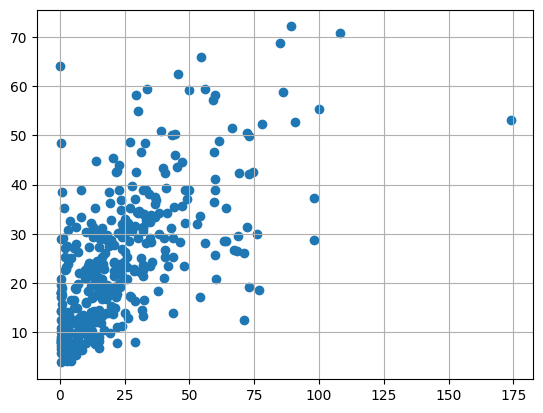

In [3]:
# Split data into input- and target data, training and test data
X = mydata_reg.drop(columns='NO3')
y = mydata_reg['NO3']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# build and fit model
model = RandomForestRegressor(random_state=1)
model.fit(X_train, Y_train)

#predict values for test set and print results
predictions = model.predict(X_test)
print("Mean absolute error: %.2f" % (mean_absolute_error(Y_test, predictions)))
print("Mean squared error: %.2f" % (mean_squared_error(Y_test, predictions)))
print("Root mean squared error: %.2f" % (np.sqrt(mean_squared_error(Y_test, predictions))))
print("R2-Score: %.2f" % ((r2_score(Y_test, predictions))))
plt.grid()
plt.scatter(Y_test, predictions)

## Berechnung der Shap-Values
Nun installieren wir zunächst das shap-Paket nach (Achtung, dies braucht man natürlich nur einmal zu machen, d.h. die entsprechende Zeile wird nach der ersten Verwendung auskommentiert). Eventuell ist es in Eurem Environment auch schon installiert, bitte ausprobieren!

Danach definieren wir zunächst einen "Explainer" (siehe [shap-Dokumentation](https://shap.readthedocs.io/en/latest/index.html), für Decision Trees eignet sich der ["TreeExplainer"](https://shap.readthedocs.io/en/latest/api.html#explainers)).
Anschließend berechnen wir die shap_values für die Trainingsdaten und plotten diese. Achtung, das kann relativ lange dauern! Alternativ kann man das auch für die Testdaten machen. Hier geht es jedoch zunächst mal darum, was das Modell warum gelernt hat, und nicht in erster Linie warum es welchen Wert bei den Testdaten vorhersagt (vor allem auch deswegen, weil die Performance mit den Testdaten nicht allzu gut ist).

In [4]:
## Die nächste Zeile wird nur benötigt, falls das shap-Paket noch nicht installiert ist.
## Dann nach der ersten Verwendung auskommentieren!
#!pip install shap 

# explain all the predictions in the training set
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


C:\Users\Tanja\miniconda3\envs\gda2_24\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Summary Plot
Zunächst schauen wir uns den sog. summary_plot an, der den Beitrag aller Features zum Modell-Output anzeigt. Die einzelnen Punkte zeigen dabei jeweils einzelne Datenpunkte an (in unserem Fall 1503 pro Feature).
Die Features werden dabei nach ihrer Wichtigkeit zur Erklärung des Outputs sortiert, d.h. das oberste Feature hat den größten Anteil. Die Farbcodierung zeigt zudem an, inwiefern der Einfluss der Werte der einzelnen Features auf den Modelloutput ist. Gut zu erkennen ist dies im Beispiel oben am Feature "landuse_num" (zur Erinnerung: dies hat nur zwei Werte, 0 für nicht landwirtschaftlich genutzt und 1 für landwirtschaftlich genutzt). Hier sieht man, dass hohe Werte (also 1), in rot dargestellt, offensichtlich zu höheren Modelloutputs (positive SHAP-values) und niedrige Werte (0, in blau) eher zu niedrigen Modelloutputs führen. Dies passt zu unserem Verständnis, dass hohe Nitrat-Werte hauptsächlich durch Düngung verursacht werden und deshalb auf landwirtschaftlich genutzten Flächen eher anzutreffen sind. Umgekehrt ist es im Mittel offensichtlich bei der Leitfähigkeit, die den größten Einfluss hat: hier hängen hohe Leitfähigkeiten eher mit höheren Nitrat-Werte zusammen und umgekehrt (wobei insgesamt die Streuung stärker ist). Auf diese Weise kann man nun alles anderen Parameter durchgehen, und analysieren, ob das, was das Modell gelernt hat, plausibel ist, d.h. zu unserem konzeptionellen Verständnis passt.

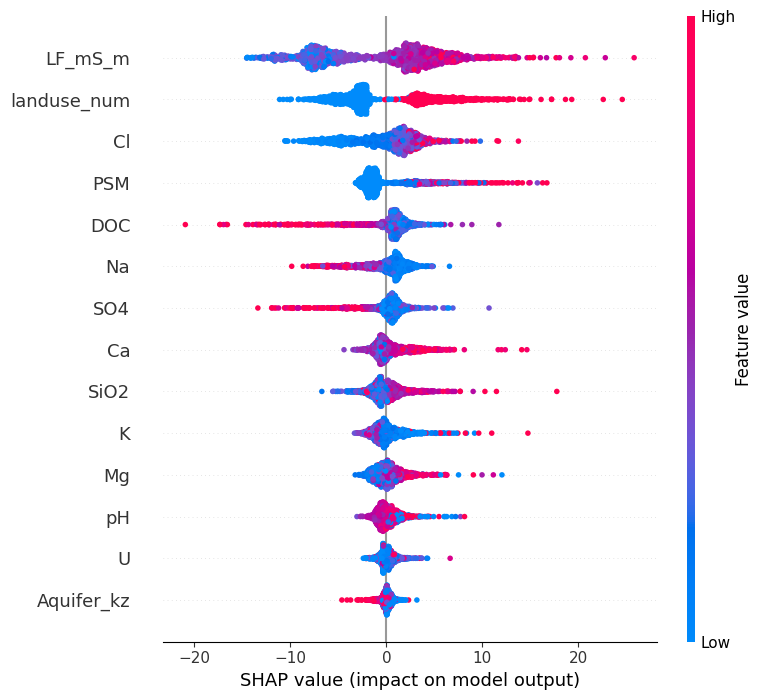

In [5]:
shap.summary_plot(shap_values, X_train)

## Dependence Plots
Mit der Funktion dependence_plot können wir uns den Einfluss einzelen Features auf den Modelloutput genauer anschauen. Jeder Punkt repräsentiert dabei eine einzelne Vorhersage (Zeile) aus dem Datensatz. Die x-Achse zeigt den Wert des Features, die y-Achse den zugehörigen Shap-Wert, der angibt, welchen Einfluss dieser Input auf die Ausgabe des Modells hat. Die Farbe entspricht hier einem zweiten Merkmal, das die stärkste Interaktion mit dem gewählten Feature hat (standardmäßig wird dieses zweite Merkmal automatisch ausgewählt, es kann aber auch explizit angegegeben oder ganz weggelassen werden). Zudem kann man xmin und xmax-Werte für die x-Achse angeben, was bei dem Vorhandensein von Ausreißern die Lesbarkeit erhöht.

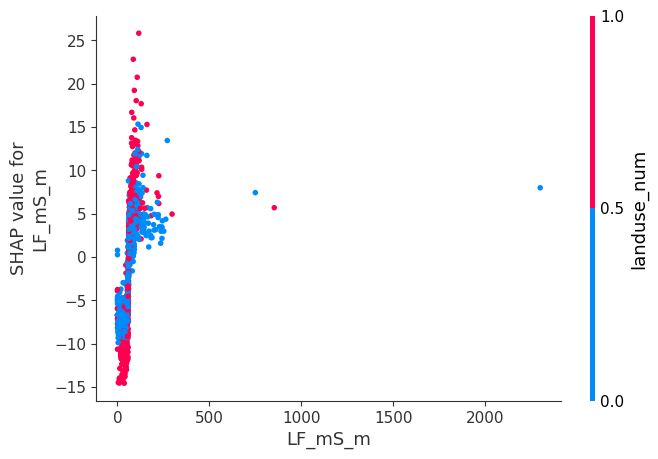

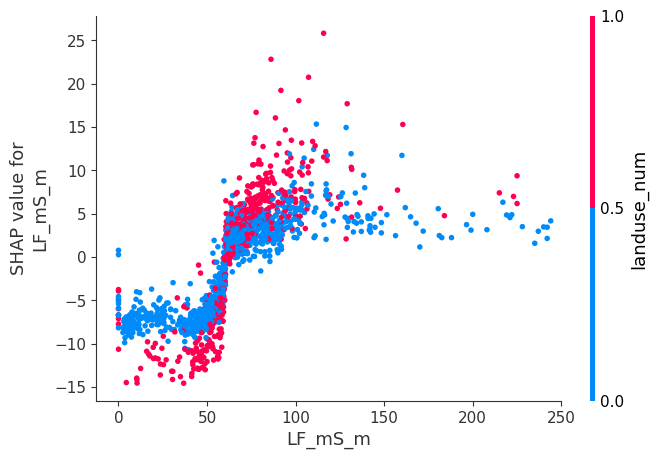

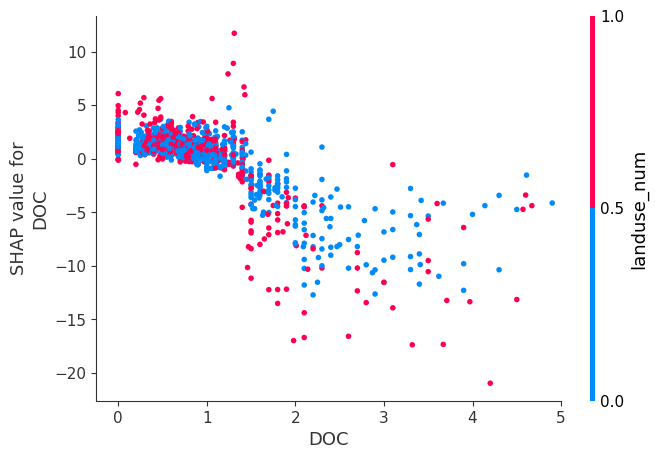

In [6]:
shap.dependence_plot("LF_mS_m", shap_values, X_train) # Beispiel Leitfähigkeit default
shap.dependence_plot("LF_mS_m", shap_values, X_train, xmax=250) # Beispiel Leitfähigkeit mit xmax
shap.dependence_plot("DOC", shap_values, X_train, interaction_index="landuse_num", xmax=5) # Beispiel DOC, der zweite Parameter wird explizit definiert.

Hier sehen wir am Beispiel der Leitfähigkeit, dass bei etwa 60 mS/m anscheinend der Einfluss plötzlich stark ansteigt. Außerdem scheinen bei den höheren Werten die landuse "1" = Landwirtschaft häufiger einen höheren Werten zu führen (das haben wir auch im summary_plot schon gesehen). Bei den niedrigen Werten ist es dagegen genau umgekehrt: hier sind es eher die landuse "0" Werte, die zu höheren Nitrat-Gehalten führen. Dies ist eine interessante Erkenntnis, für die man nun hydrogeologische Ursachenforschung betreiben könnte :-)

Beim DOC-Gehalt erscheinen hohe Nitratwerte eher mit niedrigen DOC-Gehalten zusammenzuhängen. Der Schwellenwert liegt bei etwas über 1 mg/L. Eine mögliche Erklärung könnte sein, dass unter anaeroben Bedingungen DOC zur Nitratreduktion beiträgt. Weiterhin ist (wenn auch schwach) zu erkennen, dass bei den niedrigen DOC-Werten die mit landwirtschaftlicher Nutzung (rote Punkte) eher zu hohen Nitratgehalten führen und auch insgesamt die landwirtschaftliche Nutzung eher bei den niedrigen DOC-Gehalten vorherrscht. Bei den hohen DOC-Gehalten ist dies umgekehrt, hier sind nicht landwirtschafliche Nutzungen (blaue Punkte) insgesamt häufiger - führen aber auch zu höheren Nitrat-Werten.

## Force plots

Mit dem force_plot kann man den Einfluss der Input-Features auf die Output-Vorhersage für einen einzelnen Datenpunkt darstellen. Unten wurden dazu zufällig zwei Datenpunkte ausgewählt:


In [7]:
# load JavaScript visualization code to notebook
shap.initjs()

# Beispiele Zeile 10 und 13 beliebig gewählt, gerne mit anderen Datenpunkten experimentieren!
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])


In [8]:
shap.force_plot(explainer.expected_value, shap_values[13,:], X_train.iloc[13,:])

Wir sehen, dass im Vergleich zu Shap die Ergebnisse zwar ähnlich, aber nicht ganz gleich sind. Bei dem hohen Wert führten z.B. alle shap-Werte zu einer Erhöhung gegenüber dem Mittelwert, bei Lime haben dagegen PSM und K einen negativen Eindluss.
Lime eignet sich im Gegensatz zu Shap nur für die Untersuchung der Einflussfaktoren für einzelne Vorhersagen (daher "local"). Dafür hat es aber auch eingebaute Funktionalitäten, um z.B. bei Bild oder Spracherkennung auszugeben, welche Bereiche eines Bildes bzw. welche Worte für eine Klassifikation wichtig sind. Insgesamt erscheint die Darstellung von Lime für Einzelwerte zudem etwas übersichtlicher.

Das erste Beispiel in Zeile 10 zeigt einen eher niedrigen Zielwert von  Nitrat (7.10 mg/L). Der "base value" stellt den Mittelwert aller Vorhersagen bzw. im Falle von Trainingswerten den Mittelwert aller Nitrat-Trainingsdar (23.33 mg/L). In blau dargestellt sind die Einflussfaktoren, die zur Vorhersage eines niedrigen Wertes führen, in rot die, die zu einem höheren Wert führen. Wir sehen, dass in diesem Fall landuse = 0 zu einer niedrigeren Vorhersage führte, genauso wie Sulfat, DOC usw., dagegen führten Ca, LF und Cl zu einer Erhöhung des Werts. Die Breite der Balken zeigt hier wiederum die Wichtigkeit des Einflusses an.

Beim zweiten Beispiel (Zeile 13) handelt es sich um einen vergleichsweise hohen Zielwert von Nitrat von 72.20 mg/L. Fast alle Einflussfaktoren führten in diesem Beispiel zu einem höheren Zielwert ggü. dem Mittelwert. An stärksten war der Einfluss von landuse_num, gefolgt von der LF, usw.

Allgemein sind die SHAP-Werte für einzelnen Vorhersagen im Fall der Regression jedoch eher schwierig zu interpretieren, diese eigenen sich eher für Klassifikationen.

## Übung

Suchen Sie sich ein Modell und Datensatz aus den letzten Übungen (z.B. ein MLP oder das CNN zur Zeitreihenvorhersage) aus, und wenden Sie die SHAP-Methode darauf an! Versuchen Sie, die Ergebnisse fachlich zu interpretieren. Entsprechen diese Ihrem konzeptionellen Verständnis?